In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="white", palette="husl")

%load_ext autoreload
%autoreload 2

import numpy as np
import gym
import sys
import os
if "../" not in sys.path:
    sys.path.insert(0, "../")

from algo.lstd import LSTDQ, LSTDMu, LSPI
from algo.policy import RandomPolicy2, LinearQ2
from env.simulator import * 
from util.plotting import *
from util.basis import *
from algo.fa import LinearQ3

from logger import *
setup_logging(default_level=logging.INFO)


In [2]:
env_id = "MountainCar-v0"
env = gym.envs.make(env_id)
state_dim = env.observation_space.shape[0]
# discrete action
action_dim = 1
n_action = env.action_space.n
sim = Simulator(env, state_dim=state_dim, action_dim=action_dim)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
# linear basis func
p_linear = 3
q_linear = 3
phi_linear = get_linear_basis()
psi_linear = phi_linear

include_action = False
include_action_to_basis = True


n_component = 10
n_rbf = 2
p_rbf = n_component * n_rbf + int(include_action)
q_rbf = n_component * n_rbf + int(include_action)

# https://scholarworks.umass.edu/cgi/viewcontent.cgi?referer=https://www.google.com/&httpsredir=1&article=1222&context=cs_faculty_pubs
phi_rbf = get_rbf_basis(env, n_component, include_action_to_basis, include_action)
psi_rbf = phi_rbf

phi = phi_rbf
p = p_rbf

precision = 1e-2
eps = 0.0
gamma = 0.99
action_list = range(env.action_space.n)

# DQN stuff

In [ ]:
import baselines
from baselines import deepq
import tensorflow as tf

import baselines.common.tf_util as U

from baselines.deepq.replay_buffer import ReplayBuffer
from baselines.deepq.utils import BatchInput

DQN_OFFLINE = False
DQN_ONLINE = True

def build_dqn_actor(trajs, observation_space_shape, num_actions, learning_starts = 1000, replay_buffer_size = 32):
        model = deepq.models.mlp([64], layer_norm=True)
        act, train, update_target, debug = deepq.build_train(
            make_obs_ph=lambda name: BatchInput(observation_space_shape, name=name),
            q_func=model,
            num_actions=num_actions,
            optimizer=tf.train.AdamOptimizer(learning_rate=5e-4),
        )
        
        # Create the replay buffer
        replay_buffer = ReplayBuffer(50000)
        
        # Initialize the parameters and copy them to the target network.
        U.initialize()
        update_target()
        
        # Iterate through episodes, adding the data to replay buffer
        t = 0
        e = 0
        for episode in trajs:
            e += 1
            for transition in episode:
                # Log number of transitions processed
                t += 1
                
                # Add transition to replay buffer.
                # print(act(transition.s[None])) # print the action chosen
                replay_buffer.add(transition.s, transition.a, transition.r, transition.s_next, float(transition.done))
                
                # Minimize the error in Bellman's equation on a batch sampled from replay buffer.
                if t > learning_starts:
                    obses_t, actions, rewards, obses_tp1, dones = replay_buffer.sample(replay_buffer_size)
                    td_errors = train(obses_t, actions, rewards, obses_tp1, dones, np.ones_like(rewards))
                
                # Update target network periodically.
                if t % 500 == 0:
                    update_target()
            if e % 1000 == 0:
                print('episode {0}, total transitions processed {1}'.format(e, t))
        update_target()
        return act

In [ ]:
if DQN_ONLINE:
    # Enabling layer_norm here is import for parameter space noise!
    sess = tf.InteractiveSession()
    tf.reset_default_graph()
    model = deepq.models.mlp([64], layer_norm=True)
    act = deepq.learn(
        env,
        q_func=model,
        lr=1e-3,
        max_timesteps=100000,
        buffer_size=50000,
        exploration_fraction=0.1,
        exploration_final_eps=0.1,
        print_freq=10,
        param_noise=True
    )
    print("Saving model to mountaincar_model.pkl")
    act.save("mountaincar_model.pkl")

if DQN_OFFLINE:
    tf.reset_default_graph()
    off_policy_graph = tf.Graph()
    sess = U.make_session(8, True)
    #sess = tf.Session(graph=off_policy_graph)
    act_offline = build_dqn_actor(trajs_stochastic, env.observation_space.shape, n_action)
    pi_dqn_offline = Dqn_wrapper(act_offline, param_noise=False)
    # trajs_dqn_offline = sim.simulate(pi_dqn_offline, n_trial=1, n_episode=50)
    sess.close()

In [ ]:
# Wrapper so that choose_action is exposed
class Dqn_wrapper(object):
    def __init__(self, act, param_noise = True):
        self.act = act
        self.param_noise = param_noise
    
    def choose_action(self, s):
        if self.param_noise:
            return self.act(s[None], None, None, None)[0]
        else:
            return self.act(s[None])[0]
# Instantiate
if DQN_ONLINE:
    pi_dqn = Dqn_wrapper(act)
    


# show how DQN performs using simulator

In [ ]:
# generate D using the DQN below    
D, stats = sim.simulate(pi=pi_dqn, n_trial=1, n_episode=100, return_stats=True)
plot_trajectory_mountain_car(D)
# must run this!!!
#D_mat = Simulator.to_matrix(D)

In [1]:
class NearExpertPolicy():
    """
    hard-coded near-optimal expert policy
    for mountaincar-v0
    """
    def choose_action(self, s):
        pos, v = s
        #c = np.random.uniform(-0.1, 0.1)
        c = 0
        return 0 if v <= c else 2

class OppositeNearExpertPolicy():
    """
    hard-coded near-optimal expert policy
    for mountaincar-v0
    """
    def choose_action(self, s):
        pos, v = s
        c = np.random.uniform(-0.1, 0.1)
        return 0 if v > c else 2
    
pi_near = NearExpertPolicy()
pi_near_ops = OppositeNearExpertPolicy()
pi_random = RandomPolicy2(action_list)

# if you get pi_expert error, give zero weight for it below
pi_list = [pi_random, pi_near_ops, pi_near, pi_expert]
mix_ratio = [0.0, 0.2, 0.2, 0.8]
sample_size = 100
D = sim.simulate_mixed(env, pi_list, sample_size, mix_ratio)

NameError: name 'RandomPolicy2' is not defined

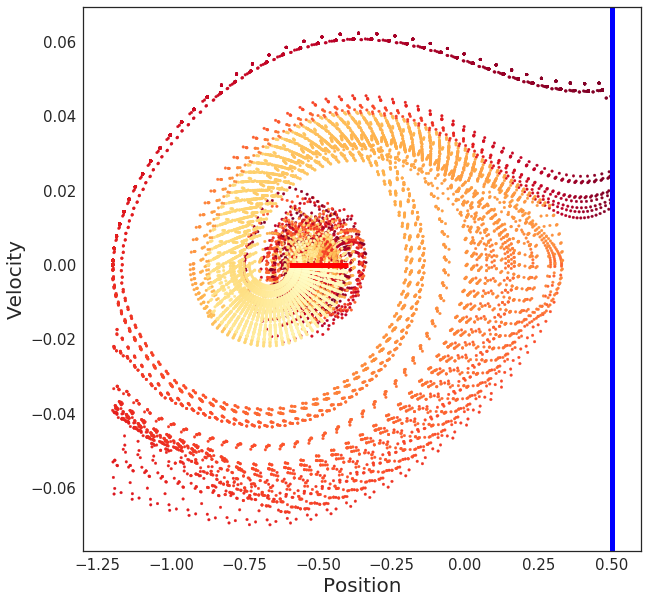

In [325]:
#plot_cost_to_go_mountain_car(env, pi_irl._estimator)
#plot_episode_stats(stZts, smoothing_window=5)
#dir(Simulator.to_matrixZ
plot_trajectory_mountain_car(D)
# must run this!!!
D_mat = Simulator.to_matrix(D)

# LSTD-mu
evlauate using monte carlo... can refer to mountain_car_lstd_mu.ipynb
